In [1]:
import numpy as np
import matplotlib 
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import Series,DataFrame
%matplotlib inline
matplotlib.style.use('ggplot')
import sklearn

from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
print(np.version.full_version)
print(matplotlib.__version__)
print(pd.__version__)
print(sklearn.__version__)

2019/05/01 23:13:17
1.16.2
3.0.3
0.24.2
0.20.3


In [25]:
features_mask_org =  ['hour', 'C1','banner_pos', 'site_id', 'site_domain', 'site_category', 
                      'app_id','app_domain', 'app_category', 
                      'device_id','device_ip', 'device_model', 'device_type', 'device_conn_type', 
                      'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

#features_mask = features_mask + ['day_week', 'hour_day']

features_unique = 'id'

target_mask = 'click'

## data reading
#date_parser = lambda x: pd.datetime.strptime(x, '%y%m%d%H')
def rawcount(filename):
    f = open(filename, 'rb')
    lines = 0
    buf_size = 1024 * 1024
    read_f = f.raw.read

    buf = read_f(buf_size)
    while buf:
        lines += buf.count(b'\n')
        buf = read_f(buf_size)

    return lines


In [14]:
fp_train = "./avazu-ctr-prediction/train.csv"

fp_train_col_counts = "./avazu-ctr-prediction/col_counts"

fp_train_f = "./avazu-ctr-prediction/train_f.csv"

fp_train_oh = "./avazu-ctr-prediction/train_f_oh.csv"


In [15]:
print(rawcount(fp_train))

40428968


In [16]:
#fp_train_col_counts の作成

## data reading
df_train_ini = pd.read_csv(fp_train, nrows = 6,
                           dtype={'id':str}, 
                           #parse_dates=['hour'],
                           #date_parser=date_parser
                          )
df_train_org = pd.read_csv(fp_train, chunksize = 5000000, iterator = True,
                           dtype={'id':str}, 
                           #parse_dates=['hour'],
                           #date_parser=date_parser
                          )


In [17]:
df_train_ini

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
5,10000720757801103869,0,14102100,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,...,1,0,16920,320,50,1899,0,431,100077,117


In [18]:

## 1.init_dict
cols_counts = {}  # the categories count for each feature
for col in features_mask_org:
    cols_counts[col] = df_train_ini[col].value_counts()

for k, v in cols_counts.items():
    print("{} : {}".format(k, v.size))

hour : 1
C1 : 1
banner_pos : 2
site_id : 3
site_domain : 3
site_category : 3
app_id : 1
app_domain : 1
app_category : 1
device_id : 1
device_ip : 6
device_model : 5
device_type : 1
device_conn_type : 2
C14 : 4
C15 : 1
C16 : 1
C17 : 3
C18 : 1
C19 : 2
C20 : 3
C21 : 3


In [19]:
## 2.counting through train-set
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
sum = 0
for chunk in df_train_org:
    sum +=  len(chunk.index)
    print("～{} : {}".format(sum, datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    for col in features_mask_org:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())
    del chunk
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

2019/05/01 23:25:17
～5000000 : 2019/05/01 23:25:32
～10000000 : 2019/05/01 23:25:53
～15000000 : 2019/05/01 23:26:15
～20000000 : 2019/05/01 23:26:37
～25000000 : 2019/05/01 23:26:59
～30000000 : 2019/05/01 23:27:24
～35000000 : 2019/05/01 23:27:57
～40000000 : 2019/05/01 23:28:24
～40428967 : 2019/05/01 23:28:34
2019/05/01 23:28:36


In [20]:
## 3.merge the deduplicates index in counting vectors
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
for col in features_mask_org:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # sort the counts
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

2019/05/01 23:28:36
2019/05/01 23:29:33


In [21]:
for k, v in cols_counts.items():
    print("{} : {}".format(k, v.size))

hour : 240
C1 : 7
banner_pos : 7
site_id : 4737
site_domain : 7745
site_category : 26
app_id : 8552
app_domain : 559
app_category : 36
device_id : 2686408
device_ip : 6729486
device_model : 8251
device_type : 5
device_conn_type : 4
C14 : 2626
C15 : 8
C16 : 9
C17 : 435
C18 : 4
C19 : 68
C20 : 172
C21 : 60


In [22]:
## 4.store the value_counting

import pickle  # to store temporary variable

print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
pickle.dump(cols_counts, open(fp_train_col_counts, 'wb'))
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))

2019/05/01 23:29:33
2019/05/01 23:29:41


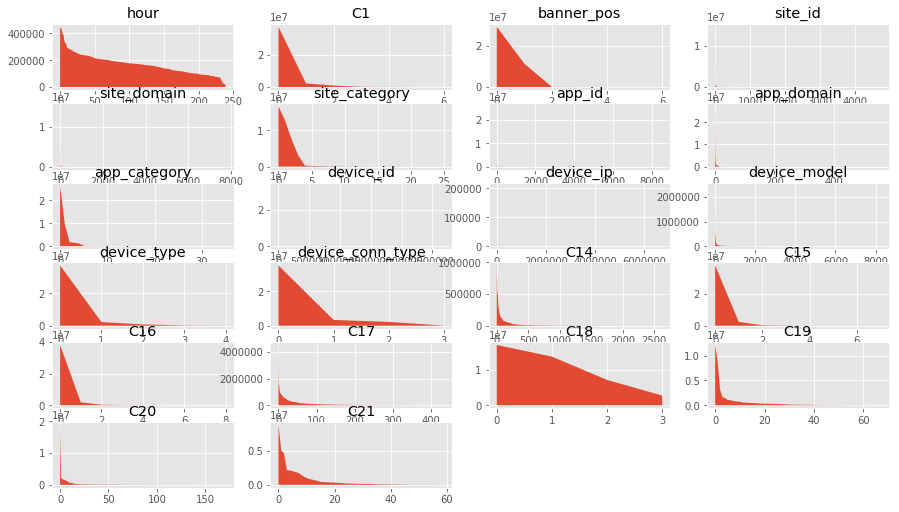

In [24]:
## 5.show the distribution of value_counts
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10
fig = plt.figure(1)
for i, col in enumerate(features_mask_org):
    ax = fig.add_subplot(7, 4, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    ax.set_title(col)
plt.show()